# Analysis of a generated data file
This notebook does the following:
 1. Load a file with an image, a target label, a set of generated rankings (attribution maps) and the measures (**average activation**, **AUC** & **activation the first point that the label is the output of the model**) of their corresponding curves.
 1. Visualizes the distribution of said metrics across the rankings.
 1. Uses Quantus to generate a few explanations, which are then used to check how each the baseline and the inverse versions of each measure correlate with the z-index of its q-value wrt the distribution.
 1. Tests the same across the whole population of rankings (by doing a train/test split) while also testing a with a varying number of baselines.

## Install packages (requires restarting runtime after running cell)

In [1]:
# Install packages.
from IPython.display import clear_output
#!pip install captum opencv-python xmltodict
#!pip install -U matplotlib
#!pip install quantus
clear_output()
#!pip install numpy --upgrade

## Load library from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PATH_DIR = '/content/drive/MyDrive/XAI-Anna-Carlos/'

import sys
sys.path.append(PATH_DIR)

import xai_faithfulness_experiments_lib as ff

Mounted at /content/drive


In [2]:
PATH_DIR = '/Users/eirasf/Desktop/eval-project/src/'
import sys
sys.path.append(PATH_DIR)
import xai_faithfulness_experiments_lib as ff

/Users/eirasf/opt/miniconda3/envs/quantus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import xai_faithfulness_experiments_lib_edits as ff_edits

## Load model

In [4]:
PATH_PRETRAINED = PATH_DIR + '../assets/models/mnist-classifier.pth'
network = ff.load_pretrained_model(PATH_PRETRAINED)

## Load randomly generated data (takes ~5min.)

In [5]:
FILENAME = PATH_DIR + '../assets/data/genetic_generated-4.npz'
data = ff.load_generated_data(FILENAME)

In [6]:
data_edits = ff_edits.load_generated_data(FILENAME)

## Quick statistics
First, we look at the distribution of the Q scores

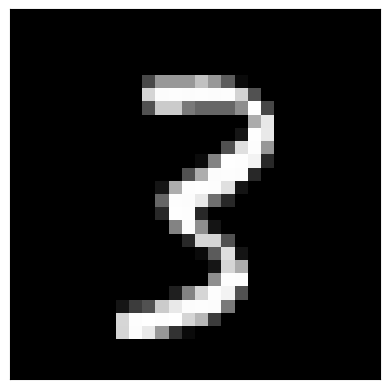

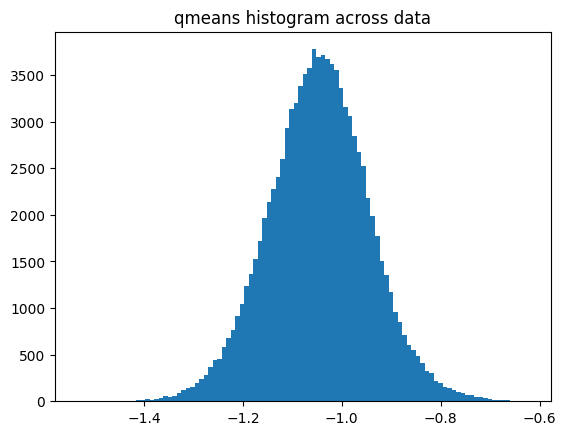

qmeans Avg=-1.0462167383427246 Std=0.10190335196041082


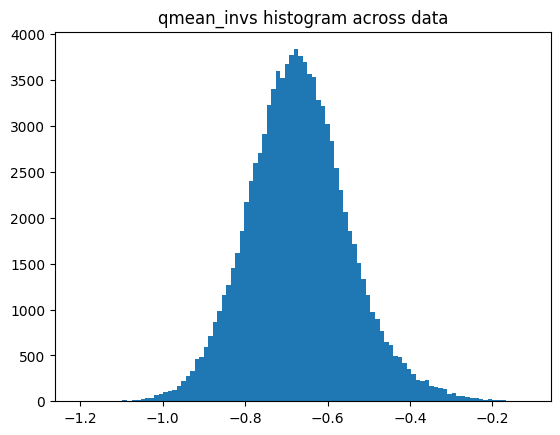

qmean_invs Avg=-0.6702207970509844 Std=0.12249419216439071


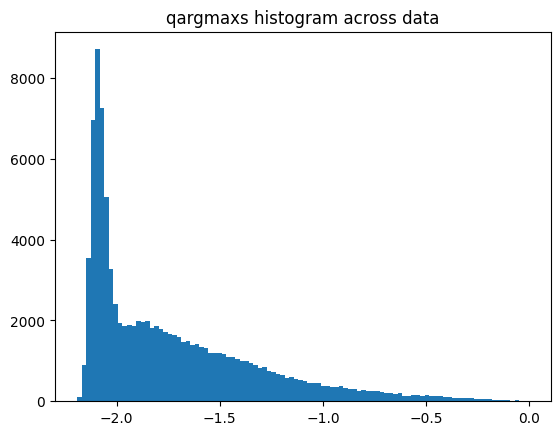

qargmaxs Avg=-1.7271363999998894 Std=0.4156662893268527


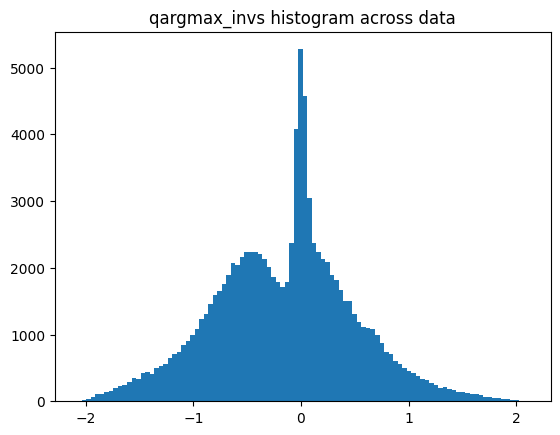

qargmax_invs Avg=-0.1544646455871081 Std=0.6473868494719803


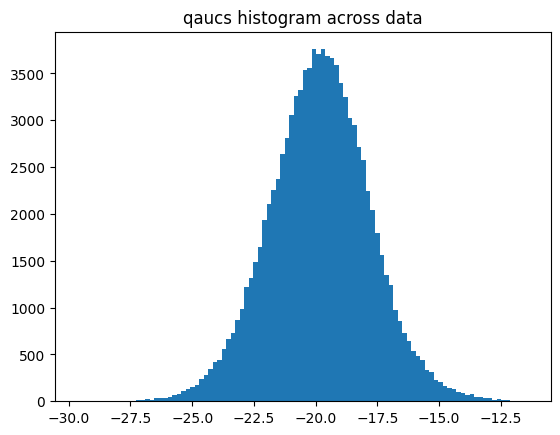

qaucs Avg=-19.828492956445377 Std=2.030676432558579


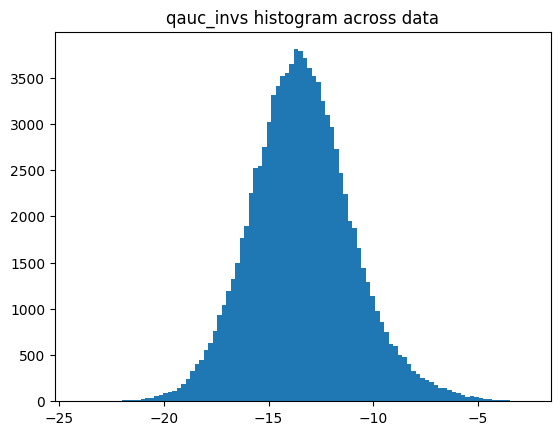

qauc_invs Avg=-13.403974569901642 Std=2.437968128846773


In [7]:
# Visualization of the image and metrics
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
plt.tight_layout()
plt.imshow(data['image'][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

averages = {}
stds = {}

for measure in ['qmeans','qmean_invs','qargmaxs','qargmax_invs','qaucs','qauc_invs']:
  plt.hist(data[measure], bins=100)
  plt.title(f'{measure} histogram across data')
  plt.show()
  averages[measure] = np.mean(data[measure])
  stds[measure] = np.std(data[measure])
  print(f'{measure} Avg={averages[measure]} Std={stds[measure]}')


## Load Quantus to compare with explanations that inspect the model

In [8]:
# Imports general.
import sys
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import captum
from captum.attr import *
import random
import os
import cv2
import PIL
from xml.etree import ElementTree
import xmltodict
import collections

import quantus

import gc
import warnings
# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

# Configs torch (read more on this cuda-related issue here: https://github.com/pytorch/pytorch/issues/45769).
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2
#clear_output()

Now we generate a few explanations using:


*   Gradient
*   GradientShap
*   InputXGradient
*   IntegratedGradients
*   Saliency

Then check their Q and Qinv and see how it compares with the random generated explanations.



In [9]:
methods = ['Gradient', 'GradientShap', 'InputXGradient', 'IntegratedGradients', 'Saliency']

explanations = {}
for method in methods:
  explanations[method] = quantus.explain(network, torch.from_numpy(data['image'].reshape((1,1,28,28))).to(device), torch.from_numpy(data['label']).to(device), method=method, normalise=True)

Let's see how they do.

In [18]:
attributions = np.squeeze(explanations['Gradient'])

ranking_image = ff._attributions_to_ranking_image(attributions)
print(ranking_image.shape)

ranking_input = ff_edits._attributions_to_ranking_row(attributions.flatten()).reshape(attributions.shape)
print(ranking_input.shape)


(28, 28)
(28, 28)


In [21]:
list(enumerate(np.random.random(7)))

[(0, 0.8936346079210367),
 (1, 0.8084637139557282),
 (2, 0.6621149897762714),
 (3, 0.541214353185513),
 (4, 0.9184888078385602),
 (5, 0.5111877281193388),
 (6, 0.8641528962439788)]

In [19]:
print(ranking_image - ranking_input)

[[-0.69731801  0.55427842  0.27203065  0.27330779  0.18135377  0.2835249
   0.23754789  0.28480204  0.27586207  0.32311622  0.25925926  0.36270754
   0.27841635  0.28607918  0.31417625  0.58365262  0.68454662  0.39591315
   0.64240102  0.69987229  0.68582375  0.54150702  0.60408685  0.42784163
   0.43550447  0.550447    0.50063857  0.45083014]
 [ 0.57598978  0.33588761  0.50957854  0.2311622   0.61302682  0.21200511
   0.21328225  0.33844189  0.17752235  0.13920817  0.12643678  0.24393359
   0.23627075  0.26181354  0.13537676  0.55555556  0.36526181  0.65900383
   0.31162197  0.71136654  0.43039591  0.53895275  0.62196679  0.4137931
   0.37931034  0.43167305  0.50319285  0.45210728]
 [ 0.37547893  0.6091954   0.27075351  0.67816092  0.41251596  0.3844189
   0.30140485  0.30779055  0.2247765   0.13154534  0.17369093  0.15197957
   0.23371648  0.12132822  0.16858238  0.75862069  0.21583653  0.6385696
   0.60025543  0.33077905  0.22222222  0.44572158  0.55300128  0.40613027
   0.37420179 

## Actual measurements of the explanations

Reminder:
qmeans: Avg=-2.9703579619936127 Std=0.36767655596813065
qmeans_inv: Avg=-2.240793897016811 Std=0.38685156126745895
(28, 28)
---- Method:Gradient [qmeans]
Actual Z-score:-5.1107
	Estimations:
		qmeans_inv:-4.7382
		qmeans_bas:-4.2212


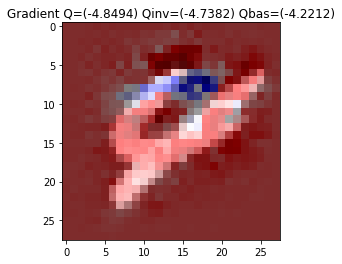

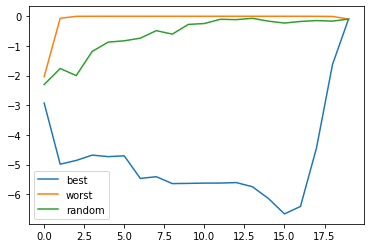

(28, 28)
---- Method:GradientShap [qmeans]
Actual Z-score:-9.5168
	Estimations:
		qmeans_inv:-6.3627
		qmeans_bas:-5.9525


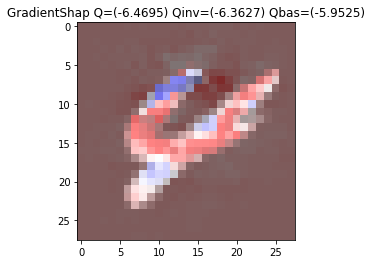

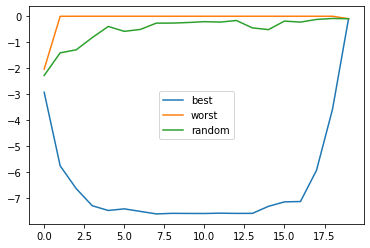

(28, 28)
---- Method:InputXGradient [qmeans]
Actual Z-score:-9.2930
	Estimations:
		qmeans_inv:-6.2803
		qmeans_bas:-5.5838


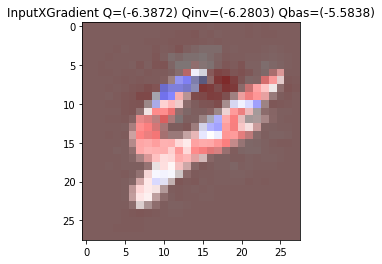

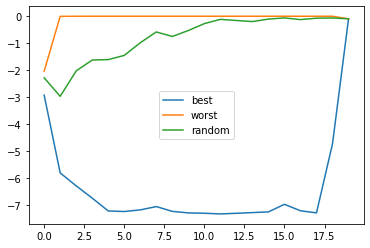

(28, 28)
---- Method:IntegratedGradients [qmeans]
Actual Z-score:-8.3691
	Estimations:
		qmeans_inv:-5.9408
		qmeans_bas:-5.4486


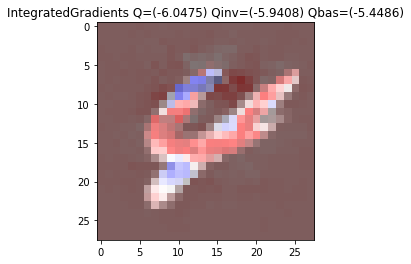

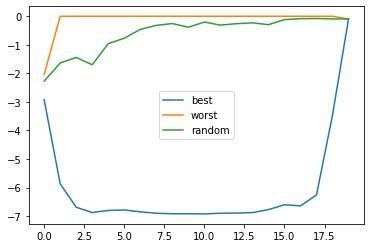

(28, 28)
---- Method:Saliency [qmeans]
Actual Z-score:1.5949
	Estimations:
		qmeans_inv:-1.8683
		qmeans_bas:-1.9829


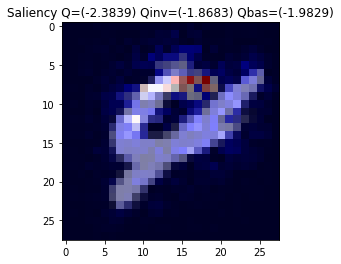

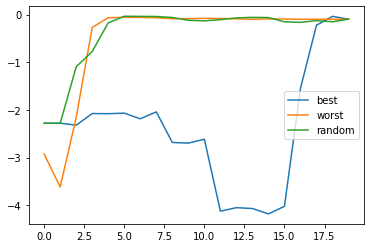

Reminder:
qargmaxs: Avg=-0.6760335748398808 Std=0.4669486709315134
qargmaxs_inv: Avg=0.468339108405702 Std=0.6647692668102048
(28, 28)
---- Method:Gradient [qargmaxs]
Actual Z-score:1.2421
	Estimations:
		qargmaxs_inv:0.0000
		qargmaxs_bas:0.0000


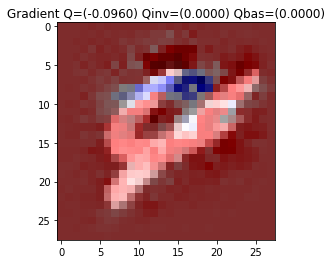

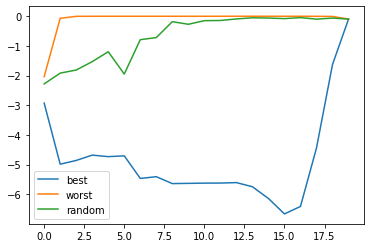

(28, 28)
---- Method:GradientShap [qargmaxs]
Actual Z-score:1.2421
	Estimations:
		qargmaxs_inv:0.0000
		qargmaxs_bas:0.0000


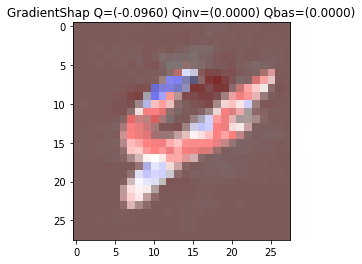

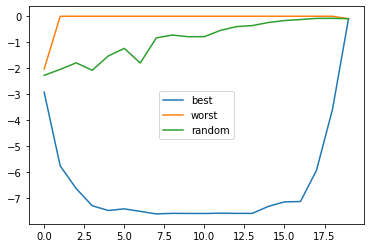

(28, 28)
---- Method:InputXGradient [qargmaxs]
Actual Z-score:1.2421
	Estimations:
		qargmaxs_inv:0.0000
		qargmaxs_bas:0.0000


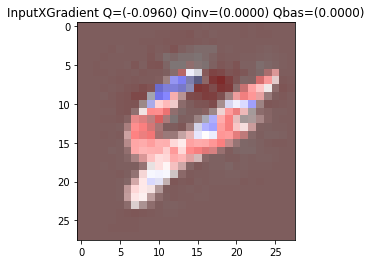

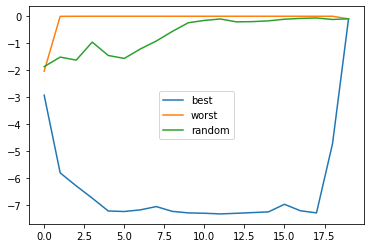

(28, 28)
---- Method:IntegratedGradients [qargmaxs]
Actual Z-score:1.2421
	Estimations:
		qargmaxs_inv:0.0000
		qargmaxs_bas:0.0000


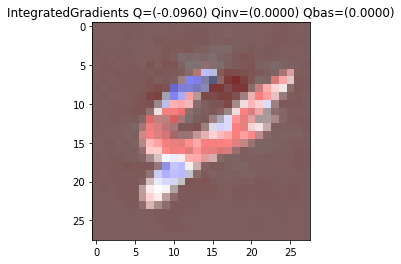

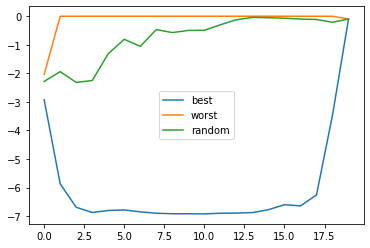

(28, 28)
---- Method:Saliency [qargmaxs]
Actual Z-score:0.9702
	Estimations:
		qargmaxs_inv:-0.1245
		qargmaxs_bas:-0.1580


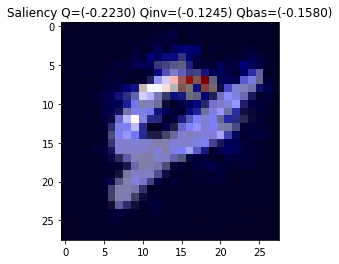

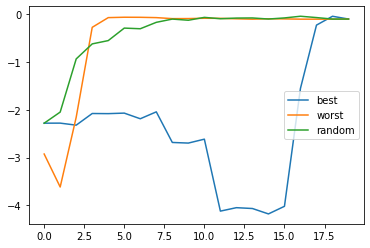

Reminder:
qaucs: Avg=-57.99150540306355 Std=7.318426317814736
qaucs_inv: Avg=-44.81787118433412 Std=7.670192858294199
(28, 28)
---- Method:Gradient [qaucs]
Actual Z-score:-5.1222
	Estimations:
		qaucs_inv:-94.3190
		qaucs_bas:-74.7317


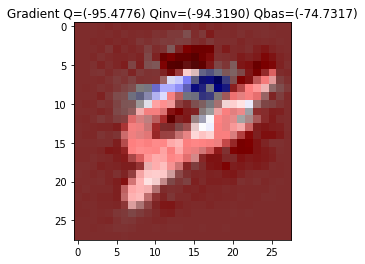

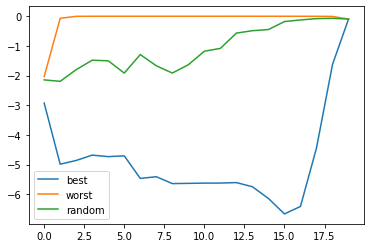

(28, 28)
---- Method:GradientShap [qaucs]
Actual Z-score:-9.5494
	Estimations:
		qaucs_inv:-126.8087
		qaucs_bas:-115.0017


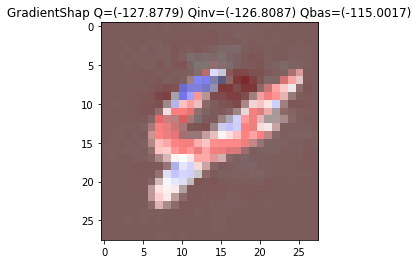

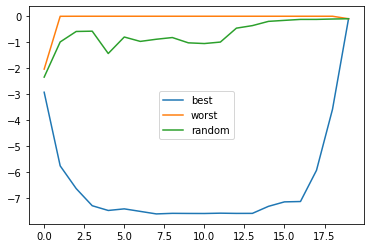

(28, 28)
---- Method:InputXGradient [qaucs]
Actual Z-score:-9.3245
	Estimations:
		qaucs_inv:-125.1603
		qaucs_bas:-110.9474


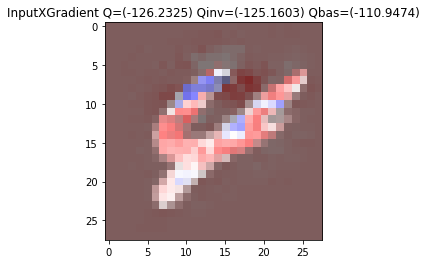

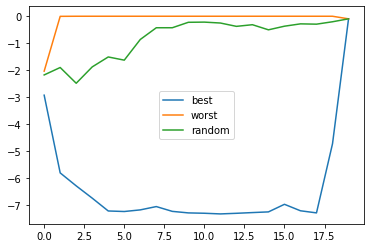

(28, 28)
---- Method:IntegratedGradients [qaucs]
Actual Z-score:-8.3963
	Estimations:
		qaucs_inv:-118.3713
		qaucs_bas:-109.8591


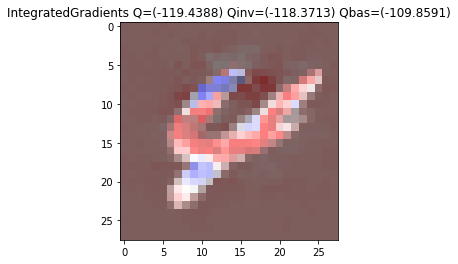

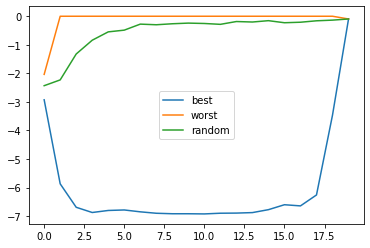

(28, 28)
---- Method:Saliency [qaucs]
Actual Z-score:1.5714
	Estimations:
		qaucs_inv:-37.6893
		qaucs_bas:-26.2461


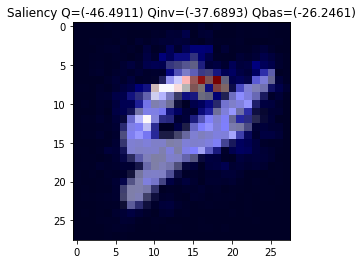

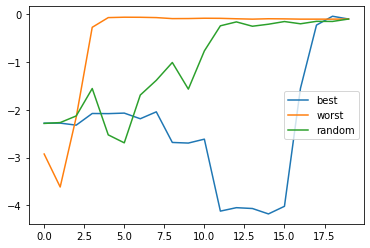

In [8]:
# I didn't use the same names in the return dict of get_measures_for_attributions,
# so I need a dictionary
equivalences = {'qmeans':'mean', \
                'qargmaxs':'at_first_argmax', \
                'qaucs':'auc'}

zscores = {}
qinv_estimations = {}
qbas_estimations = {}

for measure in ['qmeans', 'qargmaxs', 'qaucs']:
  measure_inv = measure[:-1] + '_invs'
  print("Reminder:")
  print(f'{measure}: Avg={averages[measure]} Std={stds[measure]}')
  print(f'{measure}_inv: Avg={averages[measure_inv]} Std={stds[measure_inv]}')

  zscores[measure] = np.zeros(len(methods))
  qbas_estimations[measure] = np.zeros(len(methods))
  qinv_estimations[measure] = np.zeros(len(methods))

  for i,method in enumerate(methods):
    attributions = np.squeeze(explanations[method])
    print(attributions.shape)
    result = ff.get_measures_for_attributions(torch.from_numpy(data['image']), attributions, data['label'], network, with_inverse = True, with_random = True)
    q = result[equivalences[measure]]
    qinv = result[equivalences[measure] + '_inv']
    qbas = result[equivalences[measure] + '_bas']

    print(f'---- Method:{method} [{measure}]')
    zscores[measure][i] = (q-averages[measure])/stds[measure]
    qbas_estimations[measure][i] = qbas
    qinv_estimations[measure][i] = qinv
    print(f'Actual Z-score:{zscores[measure][i]:.4f}')
    print(f'\tEstimations:')
    print(f'\t\t{measure}_inv:{qinv:.4f}')
    print(f'\t\t{measure}_bas:{qbas:.4f}')
    plt.imshow(data['image'][0], cmap='gray', interpolation='none')
    plt.imshow(explanations[method][0][0], cmap="seismic", alpha=0.5)
    plt.title(f'{method} Q=({q:.4f}) Qinv=({qinv:.4f}) Qbas=({qbas:.4f})')
    plt.show()

    plt.plot(result['output_curve'], label='best')
    plt.plot(result['output_curve_inv'], label='worst')
    plt.plot(result['output_curve_bas'], label='random')
    plt.legend()
    plt.show()
    

Let's plot estimators vs z-score.

The idea here is that the z-score wouldn't be available when evaluating how faithful an explanation is (you would need to compute the mean and std of a population of possible explanations to compute the z-score), so you need a quick computation that estimates it. People usually do `Qbas`, which is the Q score of the ranking to evaluate minus the Q score of a random ranking. We propose `Qinv` which is the Q score of the ranking to evaluate minus the Q score of the inverse of said ranking (that is, the ranking taken from end to beginning). We wnat to check which of the two is a better estimator.

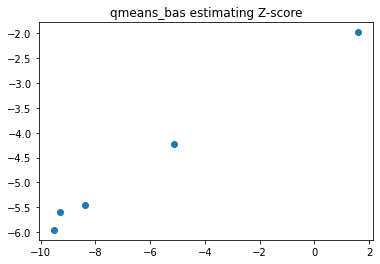

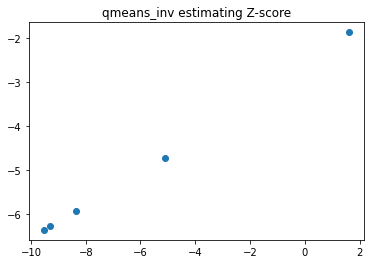

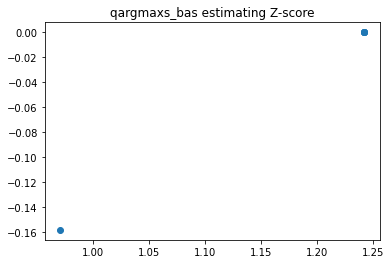

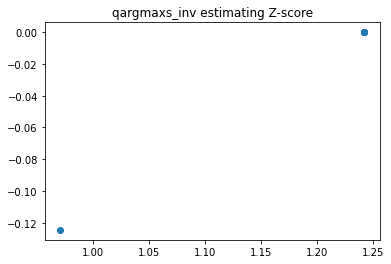

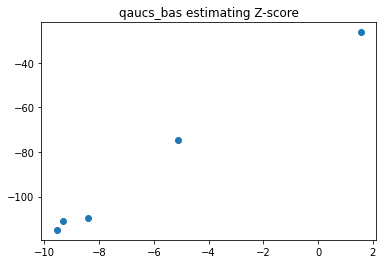

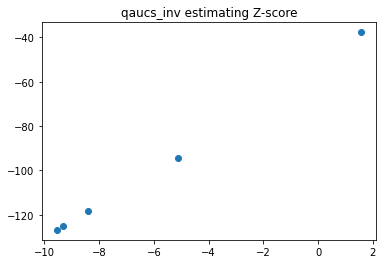

In [9]:
for measure in ['qmeans', 'qargmaxs', 'qaucs']:
  plt.scatter(zscores[measure], qbas_estimations[measure])
  plt.title(f'{measure}_bas estimating Z-score')
  plt.show()

  plt.scatter(zscores[measure], qinv_estimations[measure])
  plt.title(f'{measure}_inv estimating Z-score')
  plt.show()

It seems Qinv does a better job at estimating the Z-score. Let's check with a larger sample size.

In [10]:
# Do a 80/20 train-test split
random_indices = np.random.permutation(data['rankings'].shape[0])
num_training = int(random_indices.size*0.8)
train_indices = random_indices[:num_training]
test_indices = random_indices[num_training:]

# DEBUG - Just 10% of the data
#train_indices = train_indices[:int(0.1*num_training)]
#test_indices = test_indices[:int(0.1*num_training)]

# Load rankings
rankings_train = data['rankings'][train_indices]
rankings_test = data['rankings'][test_indices]
# Load precomputed data for those rankings

measures_train = {}
measures_test = {}
avg_q_train = {}
std_q_train = {}

for measure in ['qmeans', 'qargmaxs', 'qaucs', 'qmean_invs', 'qargmax_invs', 'qauc_invs']:
  measures_train[measure] = data[measure][train_indices]
  measures_test[measure] = data[measure][test_indices]

  # Compute the train distribution parameters that will allow the ground-truth z-score calculation
  avg_q_train[measure] = np.mean(measures_train[measure])
  std_q_train[measure] = np.std(measures_train[measure])



In [13]:
# Now we need to compute a bunch of random curve q-scores to compute qbas. Also, we compute the z-scores.
from tqdm import tqdm
number_baselines = 5 # We will test with [1-5] samples

qbas_several_samples_test = {}
zscores = {}
for measure in ['qmeans', 'qargmaxs', 'qaucs']:
  qbas_several_samples_test[measure] = np.zeros((measures_test[measure].size, number_baselines))
  zscores[measure] = np.zeros(measures_test[measure].size)
  for i in tqdm(range(measures_test[measure].size)):
    q_values = np.zeros(number_baselines)
    for j in range(number_baselines):
      # TODO - Fix visibility of these functions
      random_curve,random_is_hit = ff._get_explanation_exploratory_curve(torch.from_numpy(data['image']), ff._get_random_ranking_image(data['image'].shape[1:]), ff.NUM_SAMPLES, data['label'], network)
      if measure=='qmeans':
        q_values[j] = ff.measure_mean_activation(random_curve)
      elif measure=='qargmaxs':
        q_values[j] = ff.measure_output_at_first_argmax(random_curve, random_is_hit)
      elif measure=='qaucs':
        q_values[j] = ff.measure_auc(random_curve)
      else:
        raise Exception(f'Unknown measure "{measure}"')

    # Compute actual z-index (ground truth)
    zscores[measure][i] = (measures_test[measure][i]-avg_q_train[measure])/std_q_train[measure]

    # Compute estimators with baselines
    # Single baseline: we subtract the q for that baseline
    qbas_several_samples_test[measure][i,0] = measures_test[measure][i] - q_values[0]
    # Multiple baseline: compute parameters of poorly-sampled distribution and compute z-index for that distribution
    for j in range(1,number_baselines):
      # Estimate mean and std with only j samples
      avg_est = np.mean(q_values[:j+1])
      std_est = np.std(q_values[:j+1])
      # Update our estimator to be the z-index for this poorly-sampled distribution
      qbas_several_samples_test[measure][i,j] = (measures_test[measure][i]-avg_est)#/std_est # Turns out std estimates are too poor with so few samples

100%|██████████| 10000/10000 [01:50<00:00, 90.33it/s]


[qmeans] Pearson correlation z-score vs qbas (1-sample):0.7982302490483484


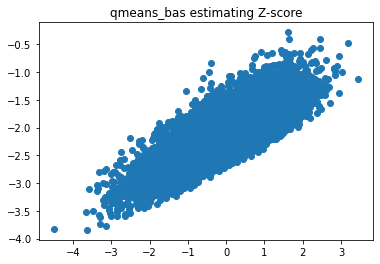

[qmeans] Pearson correlation z-score vs qbas (2-samples):0.8843274132068976


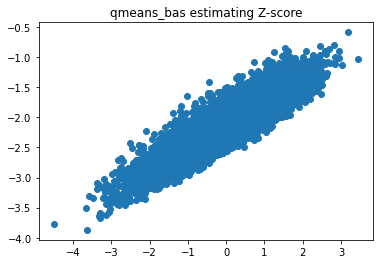

[qmeans] Pearson correlation z-score vs qbas (3-samples):0.9180431502537414


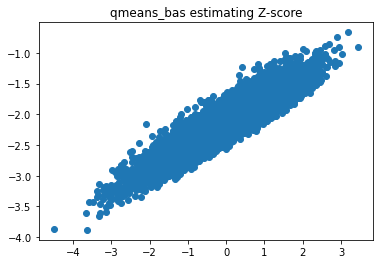

[qmeans] Pearson correlation z-score vs qbas (4-samples):0.9359696574393012


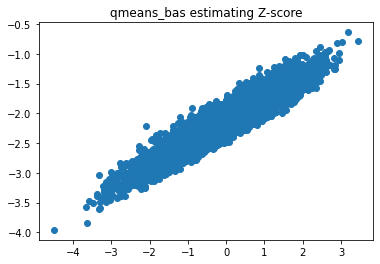

[qmeans] Pearson correlation z-score vs qbas (5-samples):0.9470307059176352


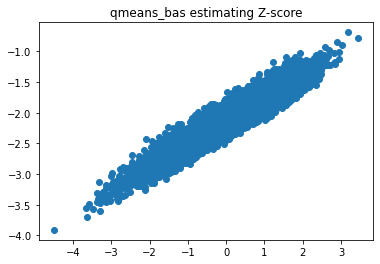

[qmeans] Pearson correlation z-score vs qinv:0.954692340532039


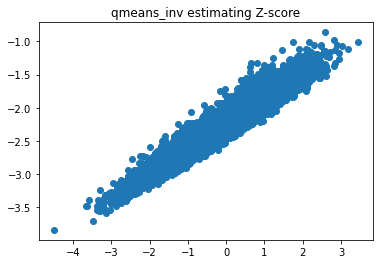

[qargmaxs] Pearson correlation z-score vs qbas (1-sample):0.7406742544254047


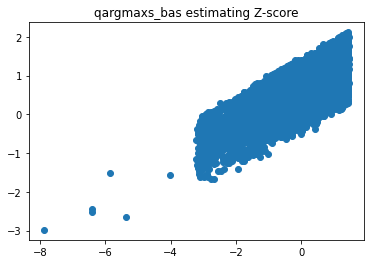

[qargmaxs] Pearson correlation z-score vs qbas (2-samples):0.8408852013773417


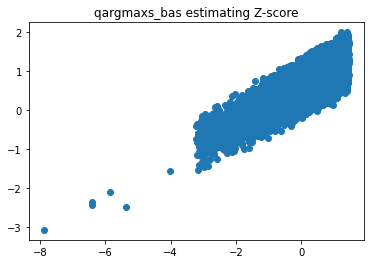

[qargmaxs] Pearson correlation z-score vs qbas (3-samples):0.8847315350181347


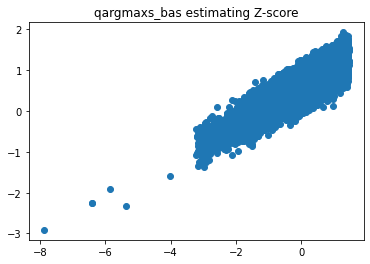

[qargmaxs] Pearson correlation z-score vs qbas (4-samples):0.909838373301648


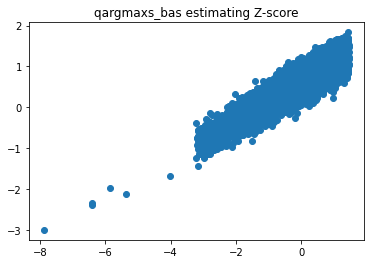

[qargmaxs] Pearson correlation z-score vs qbas (5-samples):0.9263650375080683


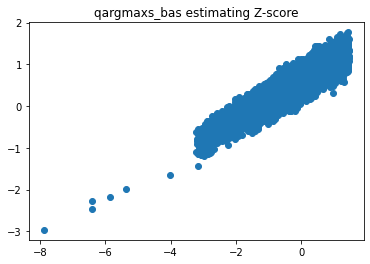

[qargmaxs] Pearson correlation z-score vs qinv:0.7015927351355609


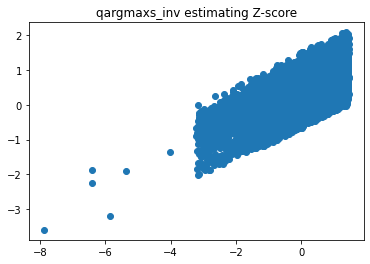

[qaucs] Pearson correlation z-score vs qbas (1-sample):0.7925350256564956


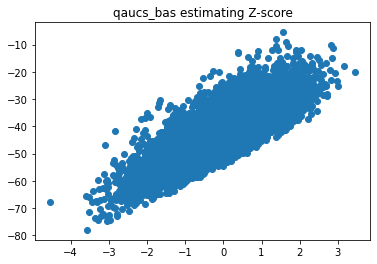

[qaucs] Pearson correlation z-score vs qbas (2-samples):0.880265617500053


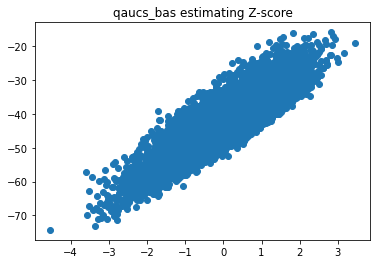

[qaucs] Pearson correlation z-score vs qbas (3-samples):0.9157272413902052


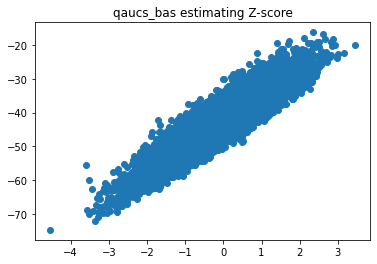

[qaucs] Pearson correlation z-score vs qbas (4-samples):0.934896493575534


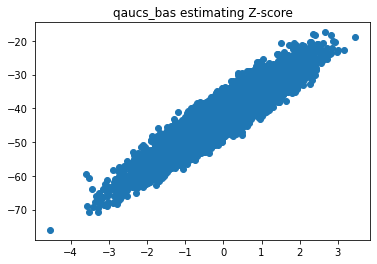

[qaucs] Pearson correlation z-score vs qbas (5-samples):0.9463205416300505


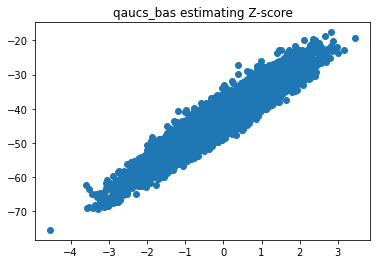

[qaucs] Pearson correlation z-score vs qinv:0.9582935831424889


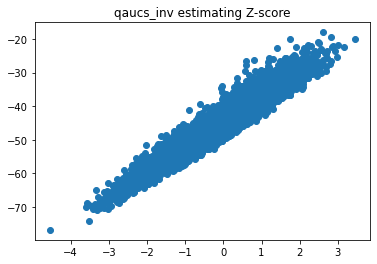

In [17]:
# Now plot the estimations
for measure in ['qmeans', 'qargmaxs', 'qaucs']:
  measure_inv = measure[:-1] + '_invs'
  for i in range(number_baselines):
    print(f'[{measure}] Pearson correlation z-score vs qbas ({i+1}-sample{"" if i==0 else "s"}):{np.corrcoef(zscores[measure],qbas_several_samples_test[measure][:,i])[0][1]}')
    plt.scatter(zscores[measure], qbas_several_samples_test[measure][:,i])
    plt.title(f'{measure}_bas estimating Z-score')
    plt.show()

  print(f'[{measure}] Pearson correlation z-score vs qinv:{np.corrcoef(zscores[measure],measures_test[measure_inv])[0][1]}')
  plt.scatter(zscores[measure], measures_test[measure_inv])
  plt.title(f'{measure}_inv estimating Z-score')
  plt.show()